In [1]:
library(Seurat)
library(hdf5r)
library(Matrix); library(stringr); library(readr)
library(here); library(fitdistrplus)
library(dplyr); library(reticulate)
library(monocle)

here() starts at /Users/kant/Desktop/CS690A/Project

Loading required package: MASS

Loading required package: survival


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘packa

In [3]:
mito_genes = c("ND1", "ND2", "COX1", "COII", "ATP8", "ATP6", "COX3", "ND3", "ND4L", "ND4", "ND5", "CYTB", "ND6")
samples = c("D4", "D7-LV", "D7-RV", "D10-LV", "D10-RV", "D14-LV", "D14-RV")

cc.genes <- NULL

filepaths <- c("/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502475_chicken_heart_scRNAseq_D4_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502476_chicken_heart_scRNAseq_D7_LV_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502477_chicken_heart_scRNAseq_D7_RV_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502478_chicken_heart_scRNAseq_D10_LV_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502479_chicken_heart_scRNAseq_D10_RV_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502480_chicken_heart_scRNAseq_D14_LV_filtered_feature_bc_matrix.h5"
,"/Users/kant/Desktop/CS690A/Project/GSE149457_RAW/GSM4502481_chicken_heart_scRNAseq_D14_RV_filtered_feature_bc_matrix.h5"
)


prepare_datasets <- function(ind, sample_name, cc.genes, mito_genes){
  # Read data
  data <- Read10X_h5(filename = filepaths[ind])
  seurat.object <- CreateSeuratObject(counts = data, min.cells = 1, min.features = 1, project = sample_name)
  # Mitrocondria
  seurat.object$percent.mito <- PercentageFeatureSet(object = seurat.object, features = mito_genes)
  return(seurat.object)
}

day4 = prepare_datasets(1, samples[1], cc.genes, mito_genes)
day7_lv = prepare_datasets(2, samples[2], cc.genes, mito_genes)
day7_rv = prepare_datasets(3, samples[3], cc.genes, mito_genes)
day10_lv = prepare_datasets(4, samples[4], cc.genes, mito_genes)
day10_rv = prepare_datasets(5, samples[5], cc.genes, mito_genes)
day14_lv = prepare_datasets(6, samples[6], cc.genes, mito_genes)
day14_rv = prepare_datasets(7, samples[7], cc.genes, mito_genes)
dim(day4)
dim(day7_lv)
dim(day7_rv)
dim(day10_lv)
dim(day10_rv)
dim(day14_lv)
dim(day14_rv)

save.image("robjs/all.objs.RData")
load("robjs/all.objs.RData")

chicken = merge(day4, y = c(day7_lv, day7_rv, day10_lv, day10_rv, day14_lv, day14_rv), add.cell.ids = samples, project = "ChickenEmbryo")
dim(chicken)
table(chicken$orig.ident)


[1] 17210  7755

[1] 16049  6413

[1] 16641  5278

[1] 13370  3048

[1] 13338  3046

[1] 12324  1988

[1] 12069  2342

[1] 18797 29870


D10-LV D10-RV D14-LV D14-RV     D4  D7-LV  D7-RV 
  3048   3046   1988   2342   7755   6413   5278 

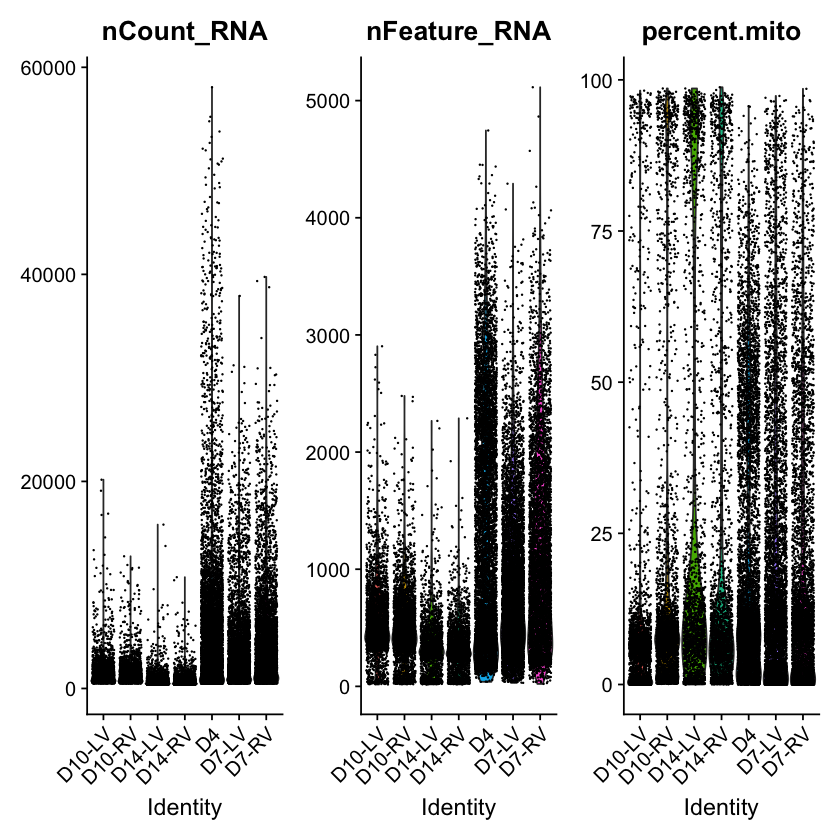

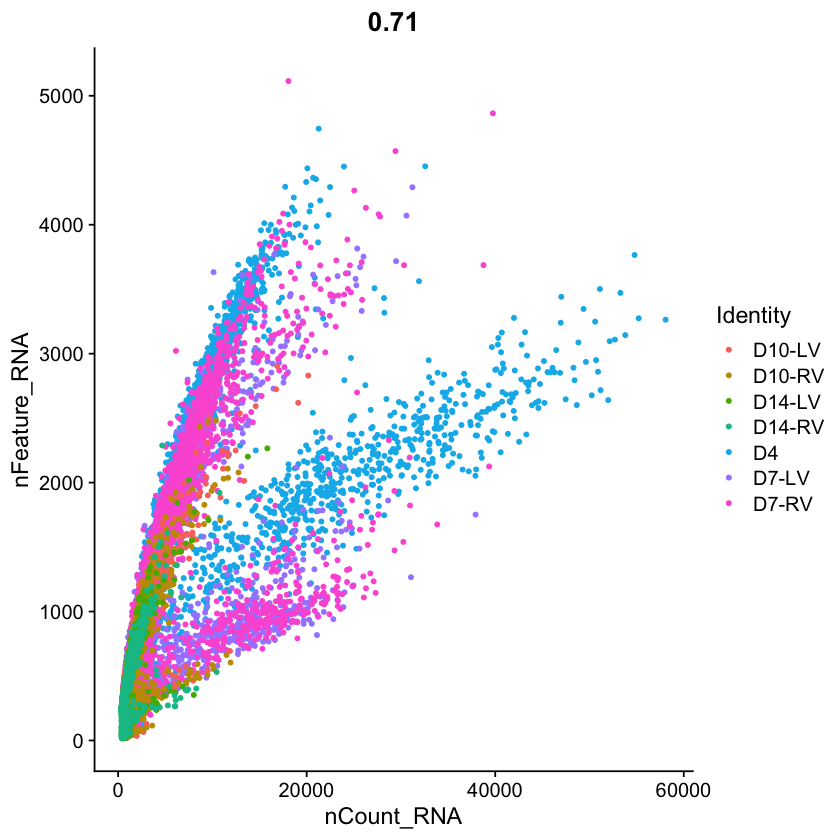

[1] 18797 22315

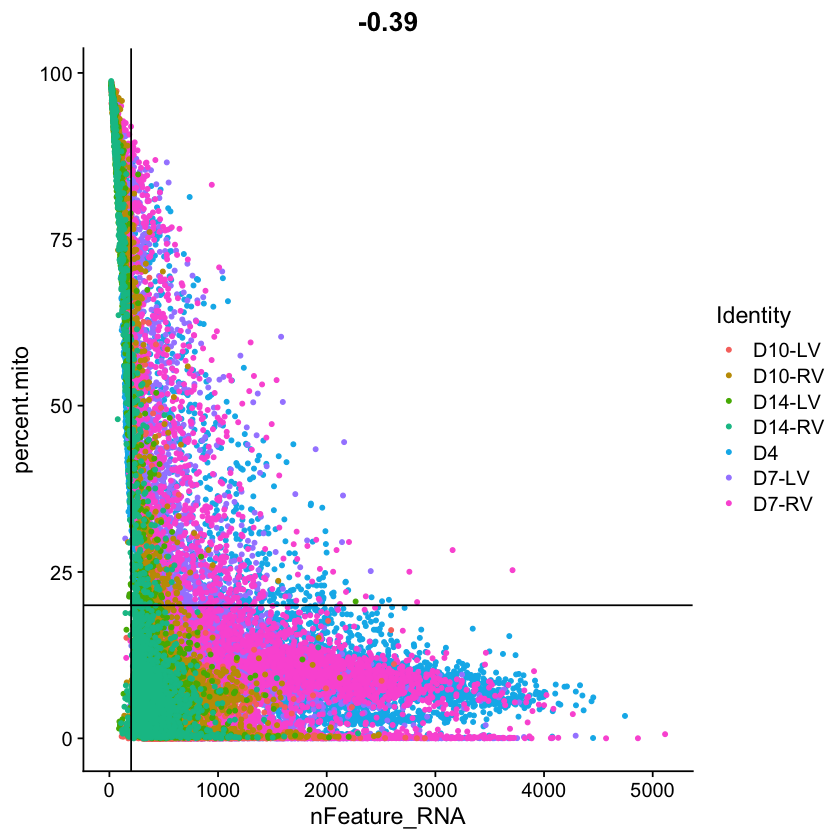

In [4]:
# Analysis starts here
VlnPlot(object = chicken, features = c("nCount_RNA", "nFeature_RNA", "percent.mito"), pt.size = 0.01, group.by = "orig.ident")
FeatureScatter(object = chicken, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
FeatureScatter(object = chicken, feature1 = "nFeature_RNA", feature2 = "percent.mito") + geom_hline(yintercept = 20) + geom_vline(xintercept = 200)

# Filter out cells with few reads and few genes.
chicken <- subset(chicken, subset = nFeature_RNA >= 200 & percent.mito <= 20)
dim(chicken)

Centering and scaling data matrix



[1]  2000 22315

PC_ 1 
Positive:  MYH9, PODXL, SPTBN1, HSP90B1, ENSGALG00000012659, SYNE2, MYH10, CCDC80, PDIA6, COL9A2 
	   TKT, FN1, TXNDC5, PHLDB2, ENSGALG00000043598, CDH11, HYOU1, TM7SF2, MFAP2, AGRN 
	   AKAP9, LMO4, GPC1, HSPA5, ENSGALG00000013239, ENSGALG00000036956, FSTL1, GATA4, LIMA1, GOLGB1 
Negative:  MYL3, FABP3, ENSGALG00000028183, TNNI1, MYL2, TNNT2, MYL10, TNNC1, EEF1A2, HSPB1 
	   ADCYAP1, ACTC1, ACTA1, TRIM55, TPM4, PLN, SMPX, CSRP3, FHL2, MYH15 
	   MYBPC3, ACTN2, APOBEC2, ENSGALG00000016826, NEBL.1, CTNNA3, NPPA, NKX2-5, ENSGALG00000016127, IRX4 
PC_ 2 
Positive:  CKB, NEXN, ADCYAP1, MYBPC3, TRIM55, MYH15, TNNT2, EEF1A2, FKBP1B, CSRP3 
	   RBM24, IRX4, LDHB, ACTN2, MYL9, ENSGALG00000016826, APOBEC2, TNNI1, MDH1, MGST3 
	   HSPB1, NEBL.1, ENSGALG00000028183, RCAN2, CYCS, SMPX, FHL2, TPM4, ENSGALG00000020788, NKX2-5 
Negative:  POSTN, DCN, FOS, COL1A1, ACTB, COL3A1, COL5A1, FN1, SPARC, CFD 
	   ENG, IFITM3, THBS1, HIC1, KLF2, ND2, AQP1, CXCL12, COL6A3, COL14A1 
	   KLF6, BRT-1, COL6

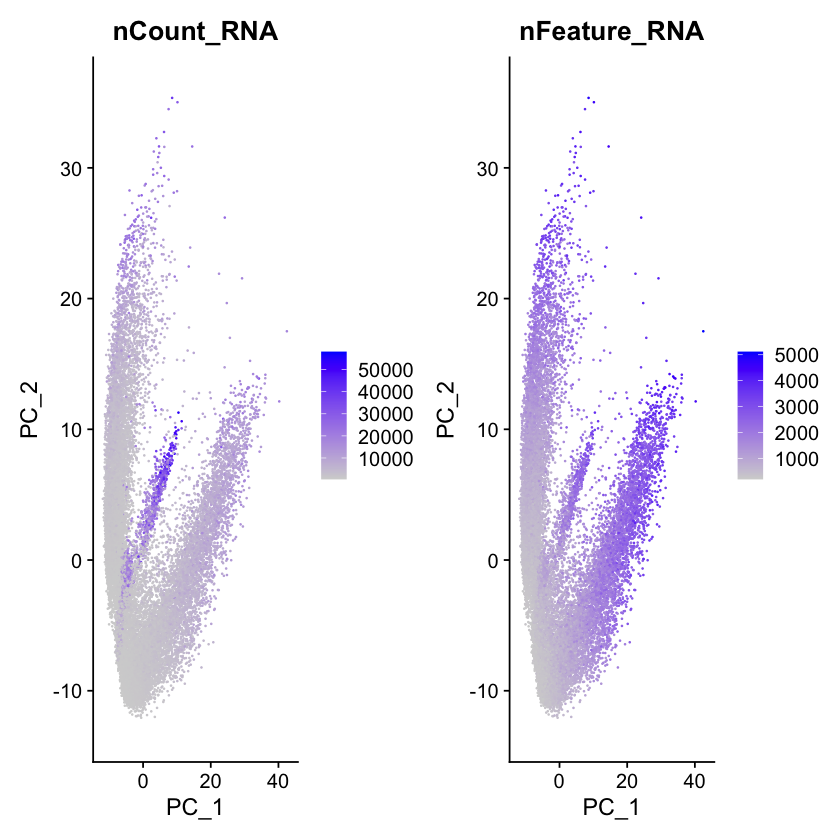

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22315
Number of edges: 798258

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9317
Number of communities: 20
Elapsed time: 5 seconds



   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3653 2519 2397 2111 1639 1311 1101  960  956  933  791  735  713  672  558  415 
  16   17   18   19 
 371  287  122   71 

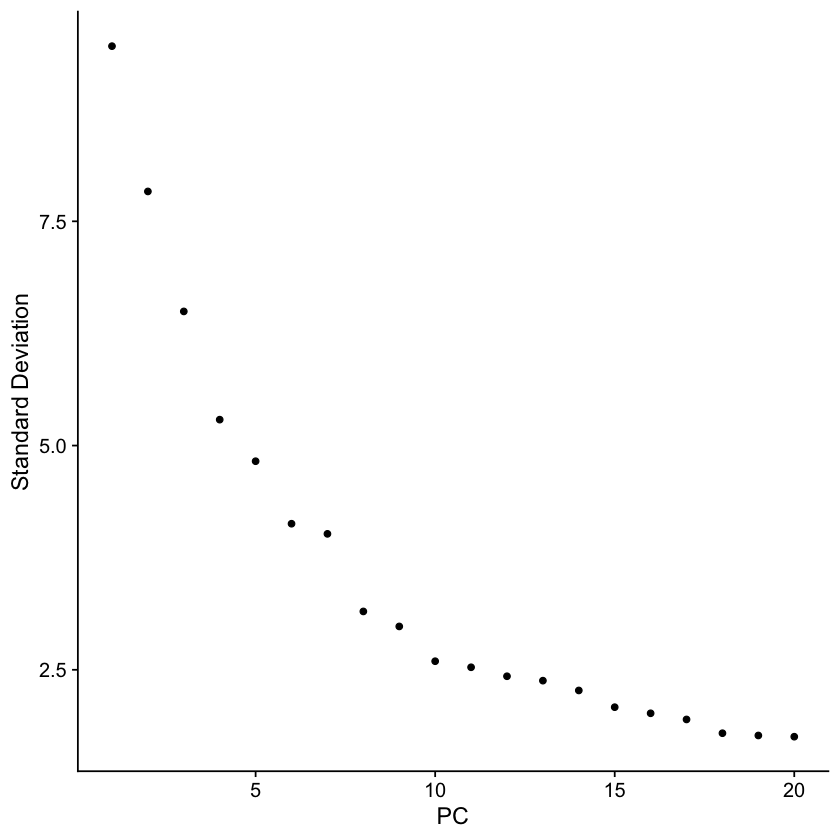

In [5]:
# Assign cell cycle score
#chicken <- CellCycleScoring(object = chicken, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes)

# Normalise, scale, and run PCA
chicken <- NormalizeData(object = chicken, scale.factor = 1e6)
chicken <- FindVariableFeatures(object = chicken, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
chicken <- ScaleData(object = chicken)
dim(GetAssayData(chicken, assay = "RNA", slot = "scale.data"))
chicken <- RunPCA(object = chicken, assay = "RNA")
FeaturePlot(chicken, reduction = "pca", c("nCount_RNA", "nFeature_RNA"))
ElbowPlot(chicken, reduction = "pca")
n.pcs = 20

# CLustering and UMAP dimesntion reduction 
chicken <- FindNeighbors(object = chicken, assay = "RNA", reduction = "pca", dims = 1:n.pcs, force.recalc = TRUE)
chicken <- FindClusters(object = chicken, resolution = 0.5)
table(Idents(chicken))



Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:41:12 UMAP embedding parameters a = 0.9922 b = 1.112

13:41:12 Read 22315 rows and found 20 numeric columns

13:41:12 Using Annoy for neighbor search, n_neighbors = 30

13:41:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:41:15 Writing NN index file to temp file /var/folders/vq/ndnwk3md0lgb3w45l4d7l6v00000gn/T//RtmpueFCeP/file1879fe69d8d

13:41:15 Searching Annoy index using 1 thread, search_k = 3000

13:41:23 Annoy recall = 100%

13:41:24 Commencing smooth kNN distance calibrat

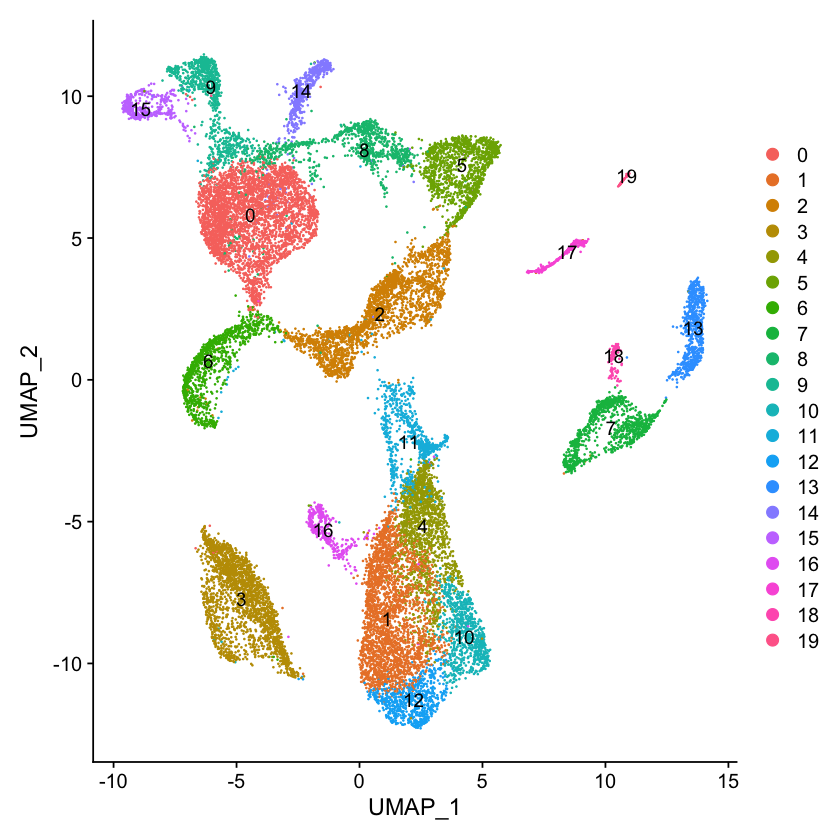

[1] 384

[1] 200

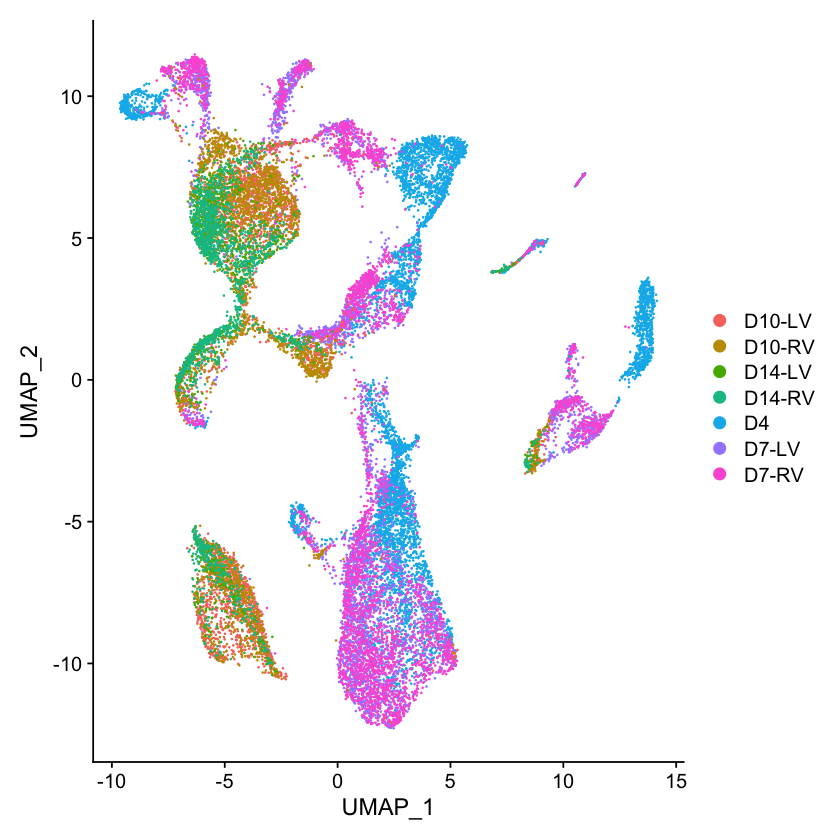

In [6]:
# To visualize
chicken <- RunUMAP(object = chicken, assay = "RNA", reduction = "pca", dims = 1:n.pcs)
DimPlot(chicken, reduction = "umap", label = TRUE, group.by = "RNA_snn_res.0.5")
DimPlot(chicken, reduction = "umap", group.by = "orig.ident")

save(chicken, file="robjs/chicken_raw.Robj")
load(here("robjs", "chicken_raw.Robj"))

min(chicken$nCount_RNA)
min(chicken$nFeature_RNA)

In [25]:
# Normalise using SC Transform method in Seurat v-3 
library(sctransform)
chicken <- SCTransform(chicken, verbose = TRUE)

# SCT creates a new SCT assay and run PCA on SCT values
DefaultAssay(chicken)
chicken <- CellCycleScoring(object = chicken, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes)
chicken <- RunPCA(object = chicken, assay = "SCT", reduction.name = "SCT_pca")
FeaturePlot(chicken, reduction = "SCT_pca", c("nCount_SCT", "nFeature_SCT"))
ElbowPlot(chicken, reduction = "SCT_pca")
n.pcs = 20

# CLustering and UMAP dimesntion reduction using SCT values
chicken <- FindNeighbors(object = chicken, assay = "SCT", reduction = "SCT_pca", dims = 1:n.pcs, force.recalc = TRUE, graph.name = "SCT_graph")
chicken <- FindClusters(object = chicken, graph.name = "SCT_graph", resolution = 0.5)
table(Idents(chicken))

# To visualize
chicken <- RunUMAP(object = chicken, assay = "SCT", reduction = "SCT_pca", dims = 1:n.pcs, reduction.name = "SCT_umap")
DimPlot(chicken, reduction = "SCT_umap", label = TRUE, group.by = "SCT_graph_res.0.5")
DimPlot(chicken, reduction = "SCT_umap", group.by = "orig.ident")

# save(chicken, file="robjs/chicken_raw_SCT.Robj")
# load(here("robjs", "chicken_raw_SCT.Robj"))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15435 by 22315

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 22315 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

Found 134 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15435 genes



  |======================================================================| 100%


Computing corrected count matrix for 15435 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.283237 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "SCT"

Warning message in AddModuleScore(object = object, features = features, name = name, :
“Could not find enough features in the object from the following feature lists: S.Score Attempting to match case...Could not find enough features in the object from the following feature lists: G2M.Score Attempting to match case...”


ERROR: Error in AddModuleScore(object = object, features = features, name = name, : The following feature lists do not have enough features present in the object: S.Score exiting...The following feature lists do not have enough features present in the object: G2M.Score exiting...


In [26]:
install.packages("SeuratData")

Warning message:
“package ‘SeuratData’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
